# Mask R-CNN Training and Testing

### This notebook uses Mask_R_CNN implemented by Matterport 
### Credits to Adam Kelly for Awesome Tutorial!



In [1]:

import os
	
os.getcwd()


'C:\\Users\\zhouz\\Projects\\poleid\\notebooks'

In [ ]:
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()

In [2]:
%load_ext autoreload

In [2]:
import os
import sys
import json
import numpy as np
import time
from PIL import Image, ImageDraw
from pathlib import Path


# Import "mrcnn" libraries
I'm using Matterport's Mask_RCNN git repo: https://github.com/matterport/Mask_RCNN

In [3]:
# Set the ROOT_DIR variable to the root directory of the Mask_RCNN git repo
ROOT_DIR = '../Mask_RCNN/'
assert os.path.exists(ROOT_DIR), 'ROOT_DIR does not exist. Did you forget to read the instructions above? ;)'

# Import mrcnn libraries
sys.path.append(ROOT_DIR) 
from mrcnn.config import Config
import mrcnn.utils as utils
from mrcnn import visualize
import mrcnn.model as modellib

Using TensorFlow backend.


# Set up logging and pre-trained model paths
This will default to sub-directories in your mask_rcnn_dir, but if you want them somewhere else, update it here.

It will also download the pre-trained coco model.

In [4]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Configuration
Define configurations for training on the box_dataset_synthetic dataset.
- Look through the code cell below and update any lines relevant to your custom dataset.
- You may want to change:
    - NAME (might want to be more specific)
    - NUM_CLASSES (always 1 + the number of object categories you have)
    - IMAGE_MIN_DIM (if you have larger training images)
    - IMAGE_MAX_DIM (if you have larger training images)
    - STEPS_PER_EPOCH (if you want to train on more images each epoch)

### Note
These are settings that worked on my machine (RTX 2070 graphics card). If you are getting OOM (Out of Memory) errors, you may need to tweak the settings or your computer may not be powerful enough. If you have a better graphics card, you will want to tweak it to take advantage of that.

In [5]:
class CocoSynthConfig(Config):
    """Configuration for training on the box_synthetic dataset.
    Derives from the base Config class and overrides specific values.
    """
    # Give the configuration a recognizable name
    NAME = "Pole_dataset"

    # Train on 1 GPU and 1 image per GPU. Batch size is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 2  # background + 7 box types

    # All of our training images are 512x512
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # You can experiment with this number to see if it improves training
    STEPS_PER_EPOCH = 1000

    # This is how often validation is run. If you are using too much hard drive space
    # on saved models (in the MODEL_DIR), try making this value larger.
    VALIDATION_STEPS = 5
    
    # Matterport originally used resnet101, but I downsized to fit it on my graphics card
    BACKBONE = 'resnet50'

    # To be honest, I haven't taken the time to figure out what these do
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 50 
    POST_NMS_ROIS_INFERENCE = 500 
    POST_NMS_ROIS_TRAINING = 1000 
    
config = CocoSynthConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

# Define the dataset

This works for datasets in coco format

In [6]:
class CocoLikeDataset(utils.Dataset):

    def load_data(self, annotation_json, images_dir):

        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()
        
        # Add the class names using the base method from utils.Dataset
        source_name = "coco_like"
        for category in coco_json['categories']:
            class_id = category['id']
            class_name = category['name']
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
                return
            
            self.add_class(source_name, class_id, class_name)
        
        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)
        
        # Get all images and add them to the dataset
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))
                
                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]
                
                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )
                
    def load_mask(self, image_id):

        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []
        
        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        
        return mask, class_ids

# Create the Training and Validation Datasets

make sure you make new directories for traing set and validation set.

In [7]:
dataset_train = CocoLikeDataset()
dataset_train.load_data('../datasets/train/coco_instances.json',
                        '../datasets/train/images')
dataset_train.prepare()

dataset_val = CocoLikeDataset()
dataset_val.load_data('../datasets/val/coco_instances.json',
                      '../datasets/val/images')
dataset_val.prepare()

## Display a few images from the train and val datasets
This will just make sure everything is set up correctly

Displaying examples from training dataset:


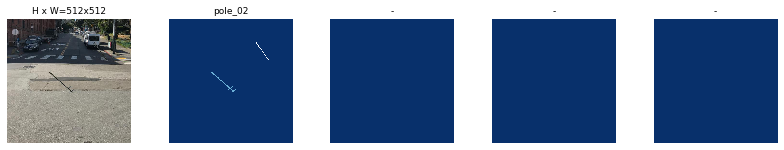

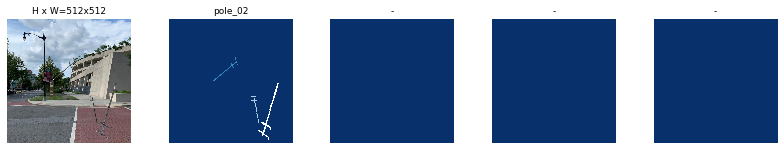

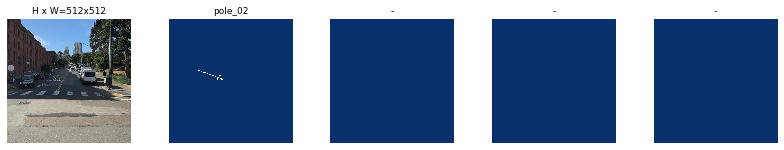

Displaying examples from validation dataset:


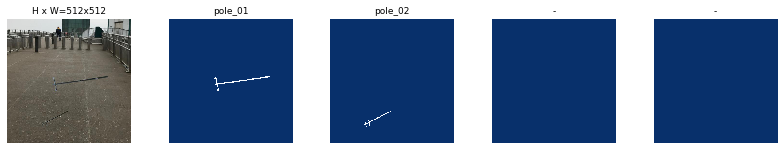

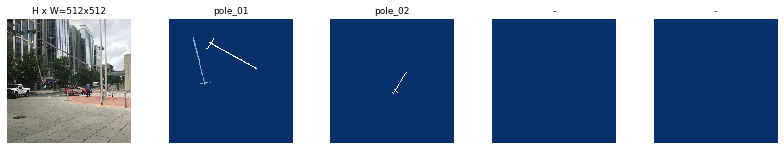

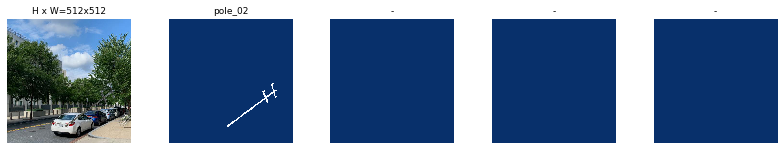

In [8]:
for name, dataset in [('training', dataset_train), ('validation', dataset_val)]:
    print(f'Displaying examples from {name} dataset:')
    
    image_ids = np.random.choice(dataset.image_ids, 3)
    for image_id in image_ids:
        image = dataset.load_image(image_id)
        mask, class_ids = dataset.load_mask(image_id)
        visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

## Create the Training Model and Train
This code is largely borrowed from the train_shapes.ipynb notebook in the Matterport repo.

In [9]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

Instructions for updating:
Colocations handled automatically by placer.


In [10]:
# Here we can use weights trained by others on Imagenet or COCO
# 'last' means load the last model you trained and continue training
init_with = "coco" 

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    model.load_weights(model.find_last(), by_name=True)

## Training
Train in two stages:

1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass layers='heads' to the train() function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass layers='all' to train all layers.

In [11]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=4, 
            layers='heads')
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 0. LR=0.001

Checkpoint Path: ../Mask_RCNN/logs\pole_dataset20190716T0030\mask_rcnn_pole_dataset_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_m

C:\Users\zhouz\Anaconda3\envs\opencvenv3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/4
1000/1000 [==============================] - 239s 239ms/step - loss: 1.8023 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.9228 - mrcnn_class_loss: 0.1737 - mrcnn_bbox_loss: 0.5575 - mrcnn_mask_loss: 0.1283 - val_loss: 1.7347 - val_rpn_class_loss: 0.0158 - val_rpn_bbox_loss: 0.6561 - val_mrcnn_class_loss: 0.4062 - val_mrcnn_bbox_loss: 0.5242 - val_mrcnn_mask_loss: 0.1324
Epoch 2/4
1000/1000 [==============================] - 228s 228ms/step - loss: 1.5658 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.8273 - mrcnn_class_loss: 0.1921 - mrcnn_bbox_loss: 0.4234 - mrcnn_mask_loss: 0.1085 - val_loss: 1.5260 - val_rpn_class_loss: 0.0128 - val_rpn_bbox_loss: 0.7579 - val_mrcnn_class_loss: 0.3213 - val_mrcnn_bbox_loss: 0.3315 - val_mrcnn_mask_loss: 0.1024
Epoch 3/4
1000/1000 [==============================] - 229s 229ms/step - loss: 1.4979 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.7659 - mrcnn_class_loss: 0.2397 - mrcnn_bbox_loss: 0.3724 - mrcnn_mask_loss: 0.1067 - val_loss: 1.5587 - val

In [12]:
# Fine tune all layers

start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=8, 
            layers="all")
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 4. LR=0.0001

Checkpoint Path: ../Mask_RCNN/logs\pole_dataset20190716T0030\mask_rcnn_pole_dataset_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_b

C:\Users\zhouz\Anaconda3\envs\opencvenv3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 5/8
1000/1000 [==============================] - 292s 292ms/step - loss: 1.3016 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.6521 - mrcnn_class_loss: 0.2399 - mrcnn_bbox_loss: 0.2873 - mrcnn_mask_loss: 0.1107 - val_loss: 1.9280 - val_rpn_class_loss: 0.0140 - val_rpn_bbox_loss: 0.7596 - val_mrcnn_class_loss: 0.5744 - val_mrcnn_bbox_loss: 0.4360 - val_mrcnn_mask_loss: 0.1439
Epoch 6/8
1000/1000 [==============================] - 274s 274ms/step - loss: 1.2123 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.6067 - mrcnn_class_loss: 0.2243 - mrcnn_bbox_loss: 0.2662 - mrcnn_mask_loss: 0.1049 - val_loss: 1.3960 - val_rpn_class_loss: 0.0093 - val_rpn_bbox_loss: 0.6262 - val_mrcnn_class_loss: 0.4347 - val_mrcnn_bbox_loss: 0.2113 - val_mrcnn_mask_loss: 0.1146
Epoch 7/8
1000/1000 [==============================] - 274s 274ms/step - loss: 1.1864 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.5811 - mrcnn_class_loss: 0.2339 - mrcnn_bbox_loss: 0.2525 - mrcnn_mask_loss: 0.1086 - val_loss: 1.8926 - val

# Prepare to run testing
Create a new InferenceConfig, then use it to create a new model.

In [13]:
class InferenceConfig(CocoSynthConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    DETECTION_MIN_CONFIDENCE = 0.85
    

inference_config = InferenceConfig()

In [14]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

Instructions for updating:
Use tf.cast instead.


### Load Trained Weights
Note: The code is set to find_last() by default, but you can also point the model to a specific pretrained weights file if you use line 3 instead of line 4.

In [15]:
# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = str(Path(ROOT_DIR) / "logs" / "box_synthetic20190328T2255/mask_rcnn_box_synthetic_0016.h5" )
model_path = model.find_last()

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  ../Mask_RCNN/logs\pole_dataset20190716T0030\mask_rcnn_pole_dataset_0008.h5
Re-starting from epoch 8


# Image Testing

I tried on some synthetic images and some real images


Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  252.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  147.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  int32
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


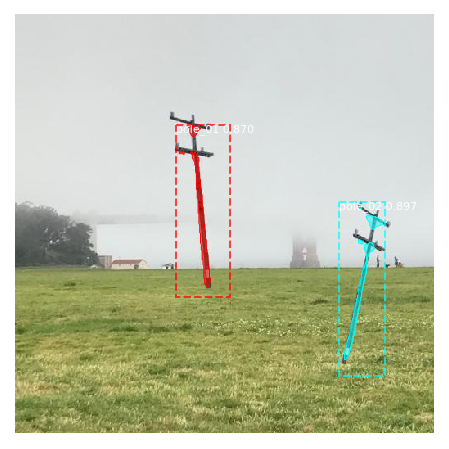

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  int32
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


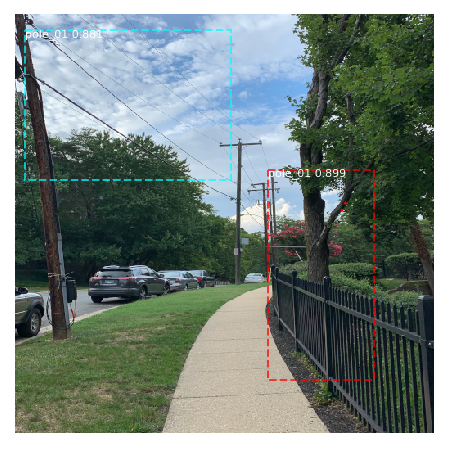

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  248.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  144.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  int32
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


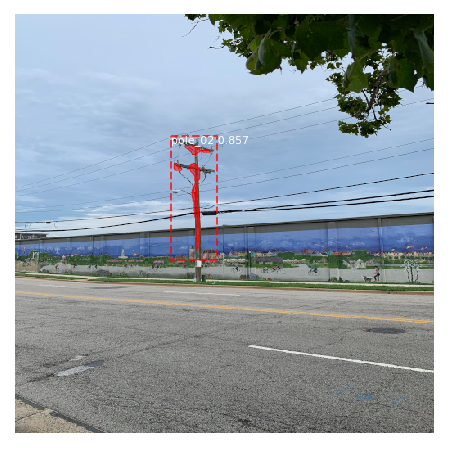

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -112.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  int32
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32

*** No instances to display *** 



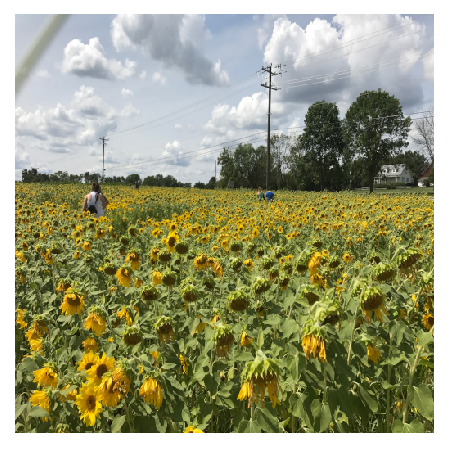

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  int32
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32

*** No instances to display *** 



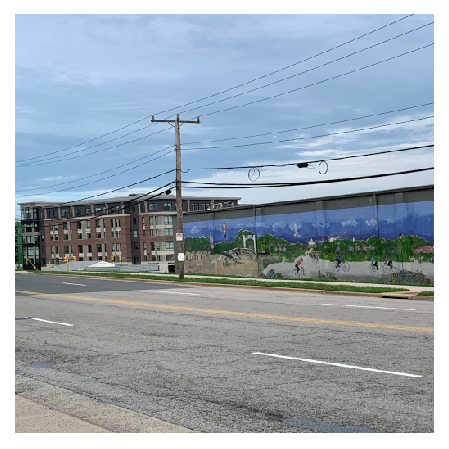

In [19]:
import skimage

real_test_dir = '../datasets/test'
image_paths = []
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_train.class_names, r['scores'], figsize=(8,8))

</br>
</br>

# Will be updated in the future